In [5]:
# Import do_mpc package:
import do_mpc
import numpy as np

In [6]:
model_type = 'continuous' # either 'discrete' or 'continuous'
model = do_mpc.model.Model(model_type)

In [7]:
phi_1 = model.set_variable(var_type='_x', var_name='phi_1', shape=(1,1))
phi_2 = model.set_variable(var_type='_x', var_name='phi_2', shape=(1,1))
phi_3 = model.set_variable(var_type='_x', var_name='phi_3', shape=(1,1))
# Variables can also be vectors:
dphi = model.set_variable(var_type='_x', var_name='dphi', shape=(3,1))
# Two states for the desired (set) motor position:
phi_m_1_set = model.set_variable(var_type='_u', var_name='phi_m_1_set')
phi_m_2_set = model.set_variable(var_type='_u', var_name='phi_m_2_set')
# Two additional states for the true motor position:
phi_1_m = model.set_variable(var_type='_x', var_name='phi_1_m', shape=(1,1))
phi_2_m = model.set_variable(var_type='_x', var_name='phi_2_m', shape=(1,1))

In [8]:
# As shown in the table above, we can use Long names or short names for the variable type.
Theta_1 = model.set_variable('parameter', 'Theta_1')
Theta_2 = model.set_variable('parameter', 'Theta_2')
Theta_3 = model.set_variable('parameter', 'Theta_3')

c = np.array([2.697,  2.66,  3.05, 2.86])*1e-3
d = np.array([6.78,  8.01,  8.82])*1e-5

In [9]:
model.set_rhs('phi_1', dphi[0])
model.set_rhs('phi_2', dphi[1])
model.set_rhs('phi_3', dphi[2])

In [10]:
from casadi import *

In [11]:
dphi_next = vertcat(
    -c[0]/Theta_1*(phi_1-phi_1_m)-c[1]/Theta_1*(phi_1-phi_2)-d[0]/Theta_1*dphi[0],
    -c[1]/Theta_2*(phi_2-phi_1)-c[2]/Theta_2*(phi_2-phi_3)-d[1]/Theta_2*dphi[1],
    -c[2]/Theta_3*(phi_3-phi_2)-c[3]/Theta_3*(phi_3-phi_2_m)-d[2]/Theta_3*dphi[2],
)

model.set_rhs('dphi', dphi_next)

In [12]:
tau = 1e-2
model.set_rhs('phi_1_m', 1/tau*(phi_m_1_set - phi_1_m))
model.set_rhs('phi_2_m', 1/tau*(phi_m_2_set - phi_2_m))

In [13]:
model.setup()

In [14]:
mpc = do_mpc.controller.MPC(model)

In [15]:
setup_mpc = {
    'n_horizon': 20,
    't_step': 0.1,
    'n_robust': 1,
    'store_full_solution': True,
}
mpc.set_param(**setup_mpc)

In [16]:
mterm = phi_1**2 + phi_2**2 + phi_3**2
lterm = phi_1**2 + phi_2**2 + phi_3**2

mpc.set_objective(mterm=mterm, lterm=lterm)

In [17]:
mpc.set_rterm(
    phi_m_1_set=1e-2,
    phi_m_2_set=1e-2
)

In [18]:
# Lower bounds on states:
mpc.bounds['lower','_x', 'phi_1'] = -2*np.pi
mpc.bounds['lower','_x', 'phi_2'] = -2*np.pi
mpc.bounds['lower','_x', 'phi_3'] = -2*np.pi
# Upper bounds on states
mpc.bounds['upper','_x', 'phi_1'] = 2*np.pi
mpc.bounds['upper','_x', 'phi_2'] = 2*np.pi
mpc.bounds['upper','_x', 'phi_3'] = 2*np.pi

# Lower bounds on inputs:
mpc.bounds['lower','_u', 'phi_m_1_set'] = -2*np.pi
mpc.bounds['lower','_u', 'phi_m_2_set'] = -2*np.pi
# Lower bounds on inputs:
mpc.bounds['upper','_u', 'phi_m_1_set'] = 2*np.pi
mpc.bounds['upper','_u', 'phi_m_2_set'] = 2*np.pi

In [19]:
mpc.scaling['_x', 'phi_1'] = 2
mpc.scaling['_x', 'phi_2'] = 2
mpc.scaling['_x', 'phi_3'] = 2

In [20]:
inertia_mass_1 = 2.25*1e-4*np.array([1., 0.9, 1.1])
inertia_mass_2 = 2.25*1e-4*np.array([1., 0.9, 1.1])
inertia_mass_3 = 2.25*1e-4*np.array([1.])

mpc.set_uncertainty_values(
    Theta_1 = inertia_mass_1,
    Theta_2 = inertia_mass_2,
    Theta_3 = inertia_mass_3
)

In [21]:
mpc.setup()

In [22]:
simulator = do_mpc.simulator.Simulator(model)

In [23]:
# Instead of supplying a dict with the splat operator (**), as with the optimizer.set_param(),
# we can also use keywords (and call the method multiple times, if necessary):
simulator.set_param(t_step = 0.1)

In [24]:
p_template = simulator.get_p_template()

In [25]:
type(p_template)

casadi.tools.structure3.DMStruct

In [26]:
p_template.keys()

['default', 'Theta_1', 'Theta_2', 'Theta_3']

In [27]:
def p_fun(t_now):
    p_template['Theta_1'] = 2.25e-4
    p_template['Theta_2'] = 2.25e-4
    p_template['Theta_3'] = 2.25e-4
    return p_template

In [28]:
simulator.set_p_fun(p_fun)

In [29]:
simulator.setup()

In [30]:
x0 = np.pi*np.array([1, 1, -1.5, 1, -1, 1, 0, 0]).reshape(-1,1)

In [31]:
simulator.x0 = x0
mpc.x0 = x0

In [32]:
mpc.x0['phi_1']

DM(3.14159)

In [33]:
mpc.set_initial_guess()

In [34]:
import matplotlib.pyplot as plt
import matplotlib as mpl
# Customizing Matplotlib:
mpl.rcParams['font.size'] = 18
mpl.rcParams['lines.linewidth'] = 3
mpl.rcParams['axes.grid'] = True

In [35]:
mpc_graphics = do_mpc.graphics.Graphics(mpc.data)
sim_graphics = do_mpc.graphics.Graphics(simulator.data)

In [36]:
%%capture
# We just want to create the plot and not show it right now. This "inline magic" supresses the output.
fig, ax = plt.subplots(2, sharex=True, figsize=(16,9))
fig.align_ylabels()

In [37]:
%%capture
for g in [sim_graphics, mpc_graphics]:
    # Plot the angle positions (phi_1, phi_2, phi_2) on the first axis:
    g.add_line(var_type='_x', var_name='phi_1', axis=ax[0])
    g.add_line(var_type='_x', var_name='phi_2', axis=ax[0])
    g.add_line(var_type='_x', var_name='phi_3', axis=ax[0])

    # Plot the set motor positions (phi_m_1_set, phi_m_2_set) on the second axis:
    g.add_line(var_type='_u', var_name='phi_m_1_set', axis=ax[1])
    g.add_line(var_type='_u', var_name='phi_m_2_set', axis=ax[1])


ax[0].set_ylabel('angle position [rad]')
ax[1].set_ylabel('motor angle [rad]')
ax[1].set_xlabel('time [s]')

In [38]:
u0 = np.zeros((2,1))
for i in range(200):
    simulator.make_step(u0)

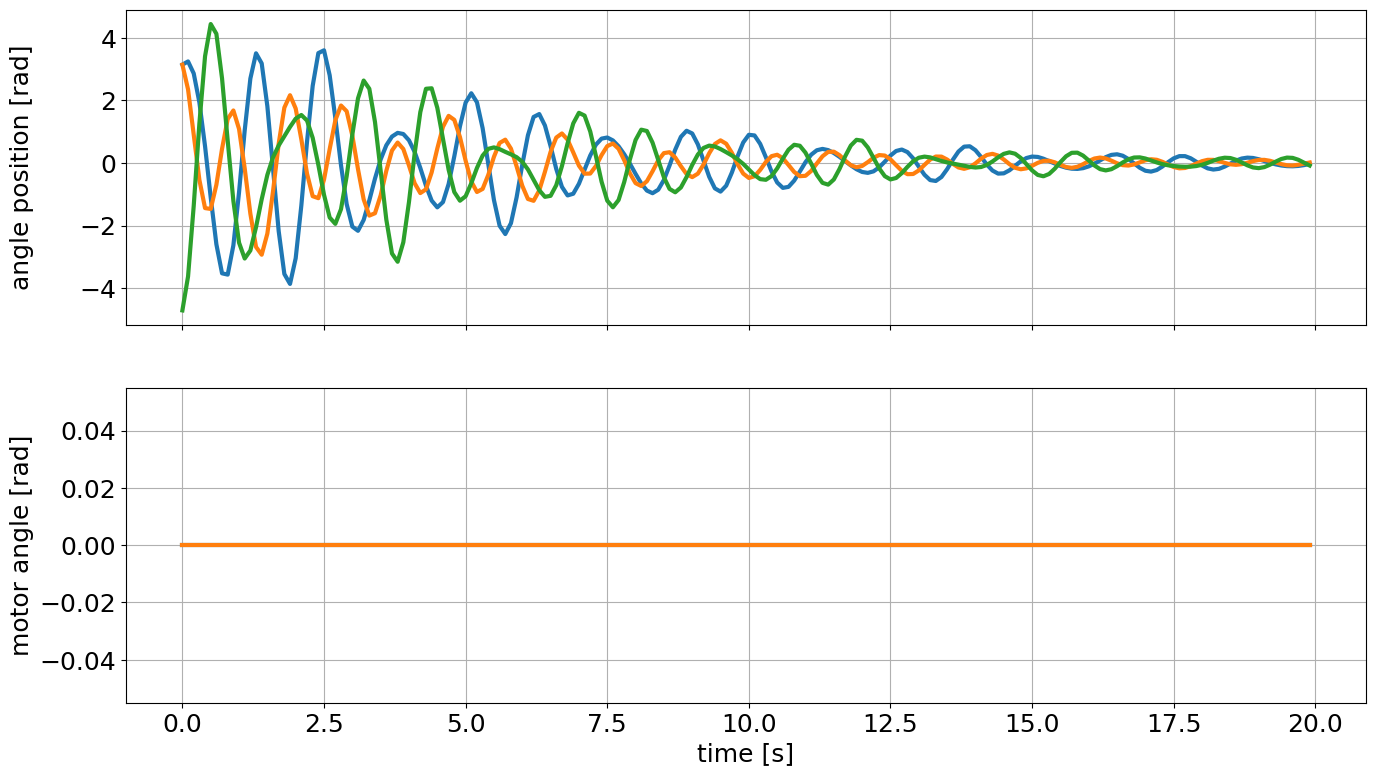

In [39]:
sim_graphics.plot_results()
# Reset the limits on all axes in graphic to show the data.
sim_graphics.reset_axes()
# Show the figure:
fig

In [40]:
u0 = mpc.make_step(x0)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    19448
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1229

Total number of variables............................:     6408
                     variables with only lower bounds:        0
                variables with lower and upper bounds:     2412
                     variables with only upper bounds:        0
Total number of equality constraints.................:     5768
Total number of inequality c

In [41]:
sim_graphics.clear()

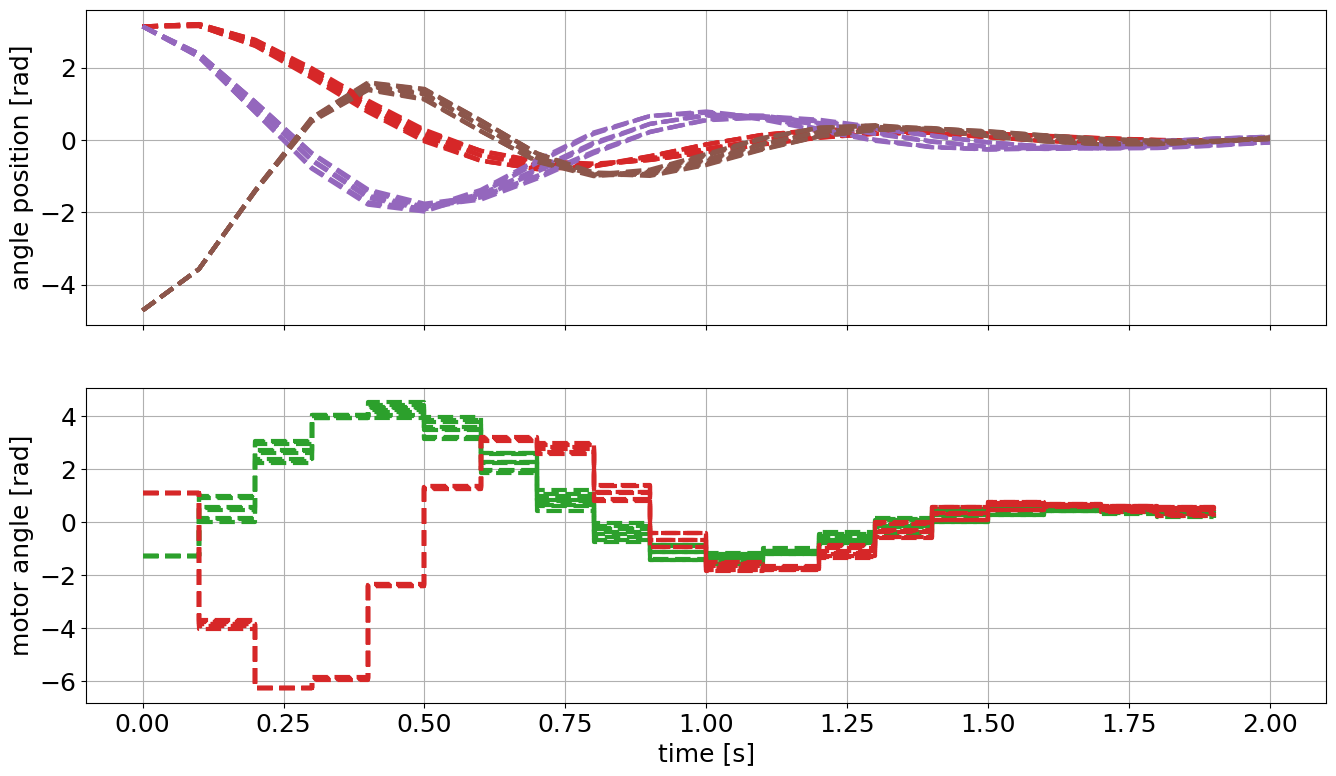

In [42]:
mpc_graphics.plot_predictions()
mpc_graphics.reset_axes()
# Show the figure:
fig

In [43]:
mpc_graphics.pred_lines

In [44]:
mpc_graphics.pred_lines['_x', 'phi_1']

In [45]:
# Change the color for the three states:
for line_i in mpc_graphics.pred_lines['_x', 'phi_1']: line_i.set_color('#1f77b4') # blue
for line_i in mpc_graphics.pred_lines['_x', 'phi_2']: line_i.set_color('#ff7f0e') # orange
for line_i in mpc_graphics.pred_lines['_x', 'phi_3']: line_i.set_color('#2ca02c') # green
# Change the color for the two inputs:
for line_i in mpc_graphics.pred_lines['_u', 'phi_m_1_set']: line_i.set_color('#1f77b4')
for line_i in mpc_graphics.pred_lines['_u', 'phi_m_2_set']: line_i.set_color('#ff7f0e')

# Make all predictions transparent:
for line_i in mpc_graphics.pred_lines.full: line_i.set_alpha(0.2)

In [46]:
# Get line objects (note sum of lists creates a concatenated list)
lines = sim_graphics.result_lines['_x', 'phi_1']+sim_graphics.result_lines['_x', 'phi_2']+sim_graphics.result_lines['_x', 'phi_3']

ax[0].legend(lines,'123',title='disc')

# also set legend for second subplot:
lines = sim_graphics.result_lines['_u', 'phi_m_1_set']+sim_graphics.result_lines['_u', 'phi_m_2_set']
ax[1].legend(lines,'12',title='motor')

In [47]:
simulator.reset_history()
simulator.x0 = x0
mpc.reset_history()

In [48]:
%%capture
for i in range(20):
    u0 = mpc.make_step(x0)
    x0 = simulator.make_step(u0)

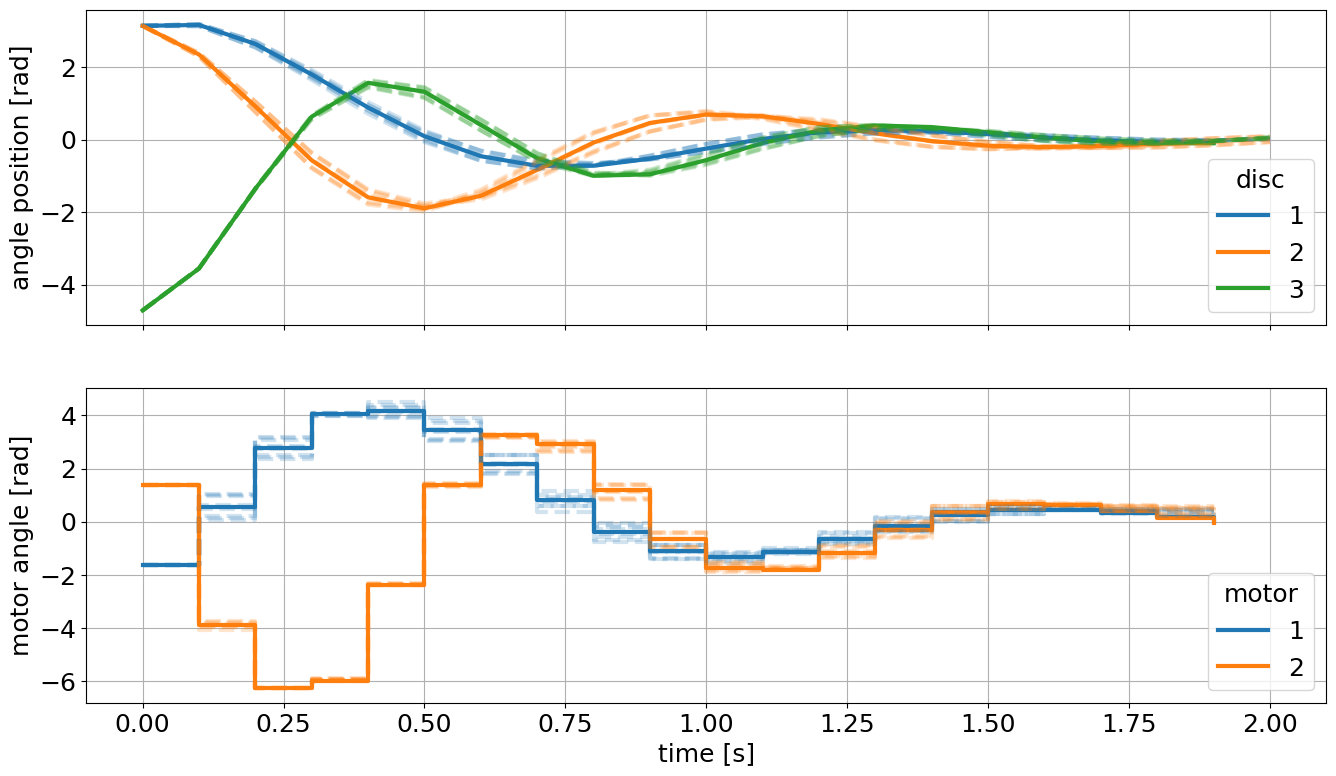

In [49]:
# Plot predictions from t=0
mpc_graphics.plot_predictions(t_ind=0)
# Plot results until current time
sim_graphics.plot_results()
sim_graphics.reset_axes()
fig

In [50]:
from do_mpc.data import save_results, load_results

In [51]:
save_results([mpc, simulator])

In [52]:
!ls ./results/

results.pkl


In [53]:
save_results([mpc, simulator])
!ls ./results/

001_results.pkl  results.pkl


In [55]:
results = load_results('./results/results.pkl')

In [56]:
results['mpc']

In [57]:
x = results['mpc']['_x']
x.shape

(20, 8)

In [58]:
phi_1 = results['mpc']['_x','phi_1']

phi_1.shape

(20, 1)

In [59]:
dphi_1 = results['mpc']['_x','dphi', 0]

dphi_1.shape

(20, 1)

In [60]:
phi_1_pred = results['mpc'].prediction(('_x','phi_1'), t_ind=0)

phi_1_pred.shape

(1, 21, 9)

In [61]:
from matplotlib.animation import FuncAnimation, FFMpegWriter, ImageMagickWriter

def update(t_ind):
    sim_graphics.plot_results(t_ind)
    mpc_graphics.plot_predictions(t_ind)
    mpc_graphics.reset_axes()

In [62]:
anim = FuncAnimation(fig, update, frames=20, repeat=False)
gif_writer = ImageMagickWriter(fps=3)
anim.save('anim.gif', writer=gif_writer)